In [240]:
!pip install -U --pre tensorflow=="2.*"

Requirement already up-to-date: tensorflow==2.* in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [0]:
import cv2 

In [0]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
import colorsys
import imghdr
import random
import scipy.io
import scipy.misc

In [244]:
!pip install pycocotools

In [245]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [246]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1082206 sha256=32e7b6feb802f149cf3880a6cbf4570bbc7e1eb546007b240669cbda7d78f025
  Stored in directory: /tmp/pip-ephem-wheel-cache-38_05p7x/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [0]:
def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = tf.stack([height, width, height, width])
    image_dims = tf.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

In [0]:
def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font='FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [0]:
def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

In [0]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [306]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)
print(len(category_index))
j=0
class_names = []
for i in range(0,list(category_index.keys())[-1]+1):
  val = list(category_index.values())
  if list(val[j].values())[0] == i:
    class_names.append(list(val[j].values())[1])
    j+=1
  else:
    class_names.append("")
print(class_names)
print(f"There are {len(class_names)} classes")
print(class_names[18])

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

90


In [254]:
}# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg')]

In [255]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [256]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [257]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

In [0]:
def run_one_image(model,image):
  ipTensor = np.asarray(image)
  ipTensor = tf.convert_to_tensor(ipTensor)
  ipTensor = ipTensor[tf.newaxis,...]

  opTensor = model(ipTensor)
  return opTensor

In [0]:
def yolo_filter_boxes(output,threshold):
  detection_scores,detection_classes,detection_boxes = output["detection_scores"],output["detection_classes"],output["detection_boxes"]
  one_hot_classes = tf.keras.utils.to_categorical(detection_classes,90)
  scores = detection_scores[0]
  scores = tf.reshape(scores, [100,1])
  box_scores = scores*one_hot_classes

  box_classes = tf.argmax(box_scores, axis=-1)
  box_class_scores = tf.math.reduce_max(box_scores, axis=-1)

  filtering_mask = box_class_scores>=threshold

  scores = tf.boolean_mask(box_class_scores,filtering_mask)
  boxes = tf.boolean_mask(detection_boxes,filtering_mask)
  classes = tf.boolean_mask(box_classes,filtering_mask)

  return scores, boxes, classes

In [0]:
def yolo(img_path,output_file,max_boxes=10,score_threshold=.6,iou_threshold=.8):
  # loading an image
  test_image = Image.open(img_path)
  # passing the image through the model
  output = run_one_image(detection_model,test_image)
  # filtering the unnecessary boxes
  scores,boxes,classes = yolo_filter_boxes(output,score_threshold)
  # non-max-supression
  selected_indices = tf.image.non_max_suppression(boxes,scores,1,0.6)
  selected_boxes = tf.gather(boxes, selected_indices)
  # getting colors
  colors = generate_colors(class_names)
  # rescaling the boxes to fit to the image
  a,b = test_image.size
  a = float(a);b = float(b)
  image_shape = (a,b)
  print(image_shape)
  boxes = scale_boxes(boxes, image_shape)
  # drawing the boxes
  draw_boxes(test_image,scores,boxes,classes,class_names,colors)
  # saving the image
  test_image.save("out/"+output_file, quality=90)
  output_image = Image.open("out/"+output_file)
  plt.imshow(output_image)
  return output_image

In [315]:
!mkdir out

mkdir: cannot create directory ‘out’: File exists


(1080.0, 1070.0)
person 0.94 (393, 215) (760, 1070)


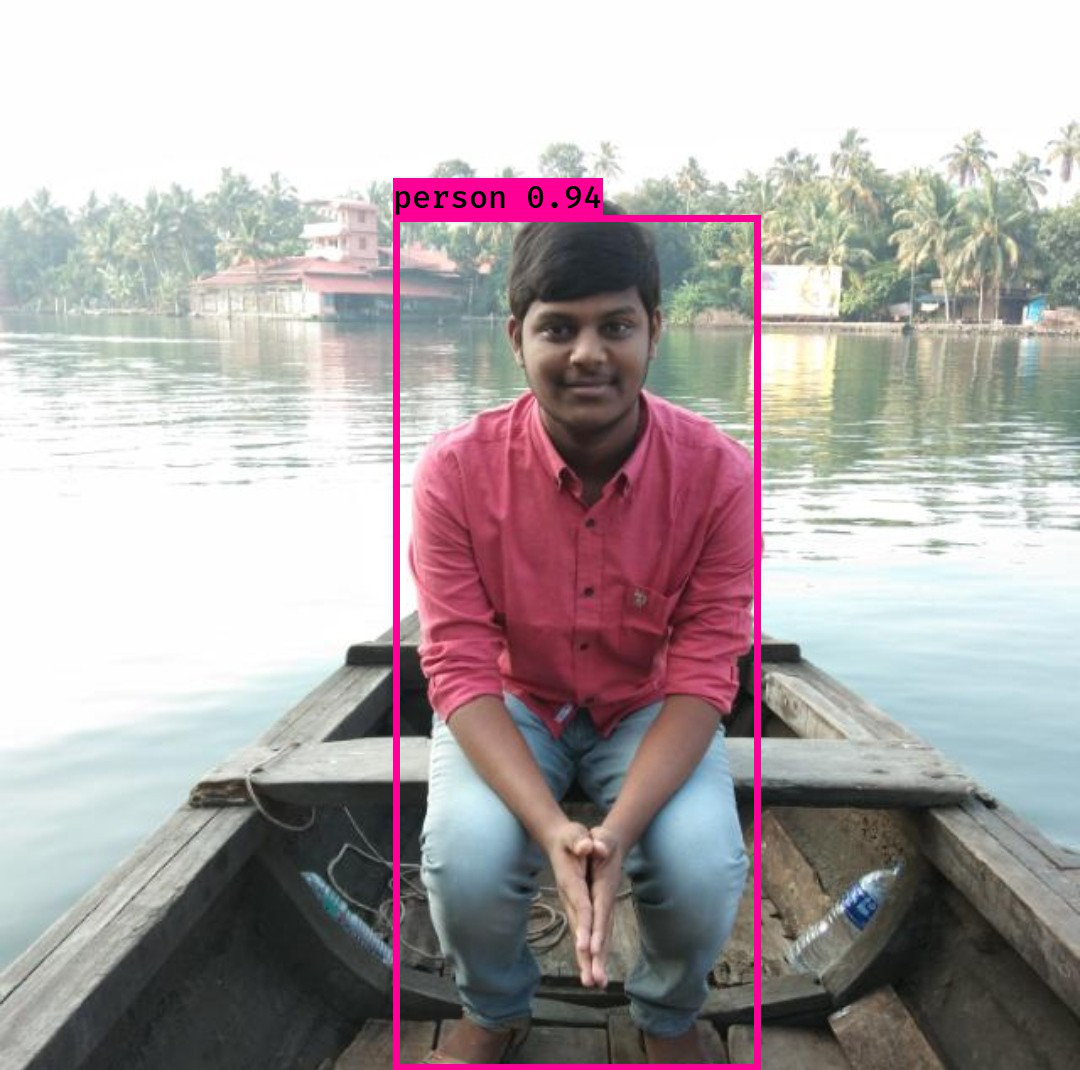

In [317]:
# Testing .....

imagePath = "Test Goutham.jpg"
outputPath = "Detected Goutham.jpg"
output = yolo(imagePath,outputPath)
Image.open("out/"+outputPath)